In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad

In [2]:
def load_Human_DLPFC(data_dir='/home/hanyuji/Data/sxa_ST_data/Human_DLPFC/', slice_names = ['151507', '151508', '151509', '151510', '151669', '151670', '151671', '151672', '151673', '151674', '151675', '151676']):
    slices = []
    for slice_name in slice_names:    
        slice = sc.read_visium(path=data_dir+str(slice_name)+'/', count_file=str(slice_name)+'_filtered_feature_bc_matrix.h5')
        coldata = pd.read_csv(data_dir+str(slice_name)+'/'+'col_data_'+str(slice_name)+'.csv')    
        slice.var_names_make_unique()
        
        spatial_coor = (coldata.loc[:, ['row', 'col']]).values
        image_coor = (coldata.loc[:, ['imagerow', 'imagecol']]).values
        spatialLIBD_cluster = (coldata.loc[:,['Cluster']]).values
        real_label = (coldata.loc[:, ['layer_guess_reordered_short']]).values
        slice.obsm['spatial_coor'] = spatial_coor
        slice.obsm['images_coordinates'] = image_coor
        slice.obs['Ground Truth'] = real_label.reshape(-1)
        slice.obs['spatialLIBD_cluster'] = spatialLIBD_cluster.reshape(-1)
        sc.pp.filter_genes(slice, min_counts = 5)
        
        slices.append(slice)

    combined_adata = ad.concat(
        slices, 
        axis=0, 
        join='outer', 
        merge='unique', 
        uns_merge='unique', 
        label='batch', 
        keys=list(range(1, len(slices)+1)), 
        index_unique='-', 
        fill_value=0
    )

    sc.pp.highly_variable_genes(combined_adata, n_top_genes=3000 ,flavor='seurat_v3')
    combined_adata = combined_adata[:, combined_adata.var.highly_variable]
    # 标准化 log 
    sc.pp.normalize_total(combined_adata, target_sum=1e4)
    sc.pp.log1p(combined_adata)

    return combined_adata

In [3]:
combined_adata = load_Human_DLPFC()

dataset_path = '/home/hanyuji/Data/sxa_ST_data/h5ad_BiGATAE/Human_DLPFC_12slices_4384spot_3000gene.h5ad'
combined_adata.write(dataset_path)

/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/hanyuji/miniconda3/envs/PASTE/lib/python3.9/site-packages/anndata/_core/anndata.py

In [5]:
combined_adata.obs

,in_tissue,array_row,array_col,Ground Truth,spatialLIBD_cluster,batch
AAACAACGAATAGTTC-1-1,1,0,16,L1,6,1
AAACAAGTATCTCCCA-1-1,1,50,102,L3,3,1
AAACAATCTACTAGCA-1-1,1,3,43,L1,2,1
AAACACCAATAACTGC-1-1,1,59,19,WM,5,1
AAACAGCTTTCAGAAG-1-1,1,43,9,L6,1,1
...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1-12,1,31,77,L6,5,12
TTGTTTCACATCCAGG-1-12,1,58,42,WM,2,12
TTGTTTCATTAGTCTA-1-12,1,60,30,WM,2,12
TTGTTTCCATACAACT-1-12,1,45,27,L6,7,12


In [15]:
unique_batches = combined_adata.obs['batch'].unique()
adatas = [combined_adata[combined_adata.obs['batch'] == batch].copy() for batch in unique_batches]
adatas[0]

AnnData object with n_obs × n_vars = 4226 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'spatialLIBD_cluster', 'batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'spatial_coor', 'images_coordinates'

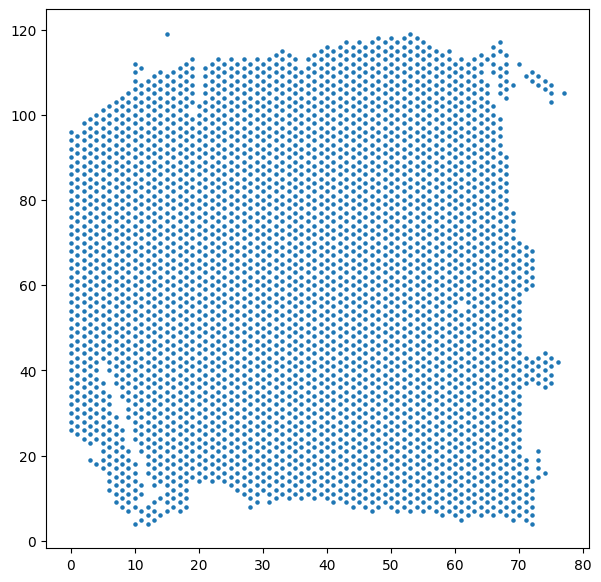

In [16]:
# AxisArrays with keys: spatial, spatial_coor, images_coordinates

df = pd.DataFrame(adatas[9].obsm['spatial_coor'])

fig = plt.figure(figsize=(7, 7))

plt.scatter(df[0], df[1],s=5)